In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors  
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
import matplotlib.patches as mpatches
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
%matplotlib inline
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option("display.max_columns", None)
pd.set_option('float_format', '{:f}'.format)


In [2]:
# creating a spark session
spark = SparkSession.builder.master("local[*]").appName("big data").getOrCreate()


# EDA

In [3]:
# Read Data
file_path="/mnt/team25/data/creditcard.csv"
df = spark.read.load(file_path,format='csv', header='true', inferSchema='true')
print('Schema overview')
df.printSchema()

Schema overview
root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V2

In [4]:
# Check Class Field
class_freq = df.groupBy("Class").count()
class_freq.show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



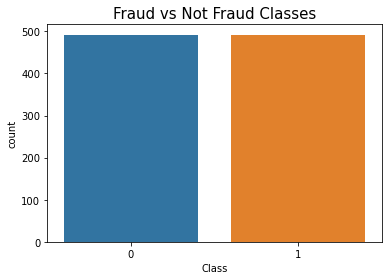

In [10]:
# Converting it into pandas for analysing 
data= df.toPandas()
data= data.sample(frac=1)
fraud_df = data.loc[data['Class'] == 1]
non_fraud_df = data.loc[data['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
new_df = normal_distributed_df.sample(frac=1, random_state=45)
sns.countplot('Class', data=new_df)
plt.title('Fraud vs Not Fraud Classes', fontsize=15)

plt.show()

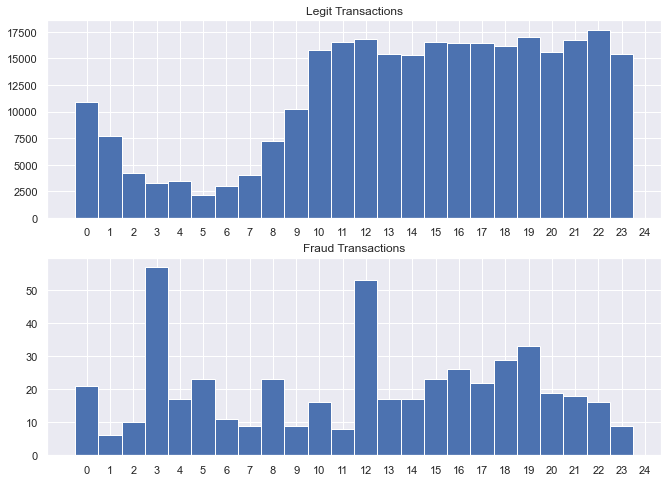

In [53]:
# checking a fraud vs non fraud pattern
import datetime
data["Hour"] = data["Time"].apply(datetime.datetime.fromtimestamp).dt.hour
sns.set(style="darkgrid")
fig_, ax_ = plt.subplots(2, figsize=(11,8))
for i in ax_:
    i.set_xticks(range(25))
    

data.loc[data["Class"] == 0]["Hour"].hist(bins=np.arange(25)-0.5, ax=ax_[0] )

data.loc[data["Class"] == 1]["Hour"].hist(bins=np.arange(25)-0.5, ax=ax_[1])

ax_[0].title.set_text("Legit Transactions")

ax_[1].title.set_text("Fraud Transactions")



plt.subplots_adjust(hspace=0.2)

So it is obvious that legitmate transaction decresases at night and increases at day

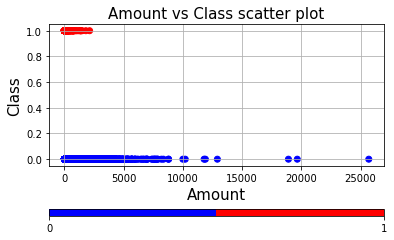

In [8]:
# Scatter Plot to check amount vs Class
cmap = colors.ListedColormap(['blue', 'red'])
plt.scatter(x=data["Amount"], y=data["Class"], c=data["Class"], cmap=cmap)
plt.colorbar(ticks=[0, 1], orientation='horizontal', aspect=50, pad = 0.20)

plt.title("Amount vs Class scatter plot", fontsize=15)
plt.ylabel("Class", fontsize=15)
plt.xlabel("Amount", fontsize=15)
plt.grid()

We can see fraud is mostly done for less amount of data

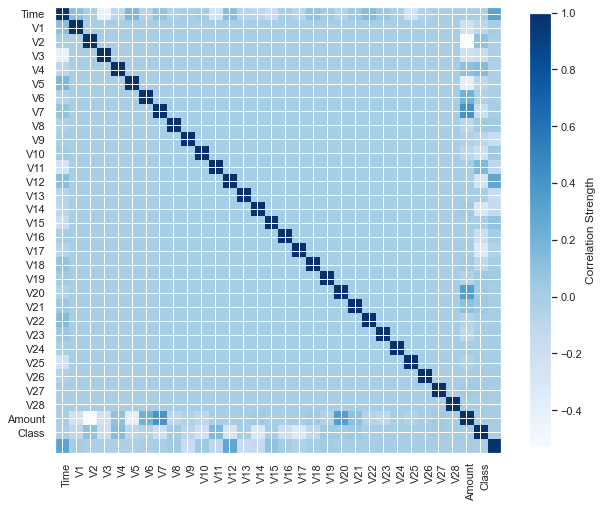

In [54]:
# correlation for Imbalance Data
corr = data.corr()
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(corr, cmap='Blues')
ax.set_xticks(np.arange(len(new_df.columns)))
ax.set_yticks(np.arange(len(new_df.columns)))
ax.set_xticklabels(new_df.columns, rotation=90)
ax.set_yticklabels(new_df.columns)
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")
plt.colorbar(im, aspect=20, shrink = 0.80 , pad = 0.05, label='Correlation Strength')
plt.show()

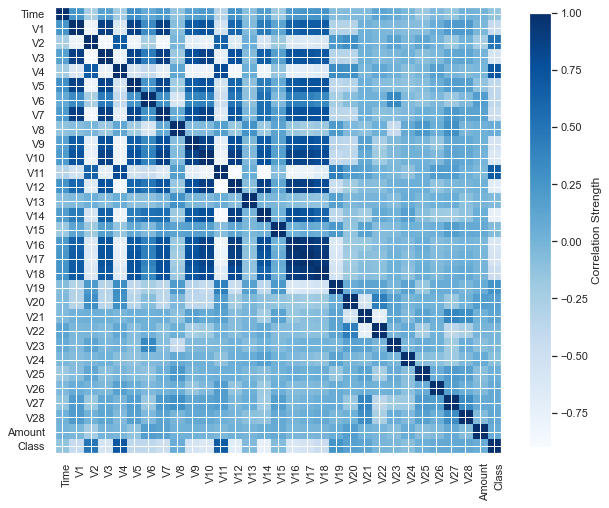

In [56]:
# correlation for balanced Data
corr = new_df.corr()
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(corr, cmap='Blues')
ax.set_xticks(np.arange(len(new_df.columns)))
ax.set_yticks(np.arange(len(new_df.columns)))
ax.set_xticklabels(new_df.columns, rotation=90)
ax.set_yticklabels(new_df.columns)
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")
plt.colorbar(im, aspect=20, shrink = 0.80 , pad = 0.05, label='Correlation Strength')
plt.show()


<Figure size 432x288 with 0 Axes>

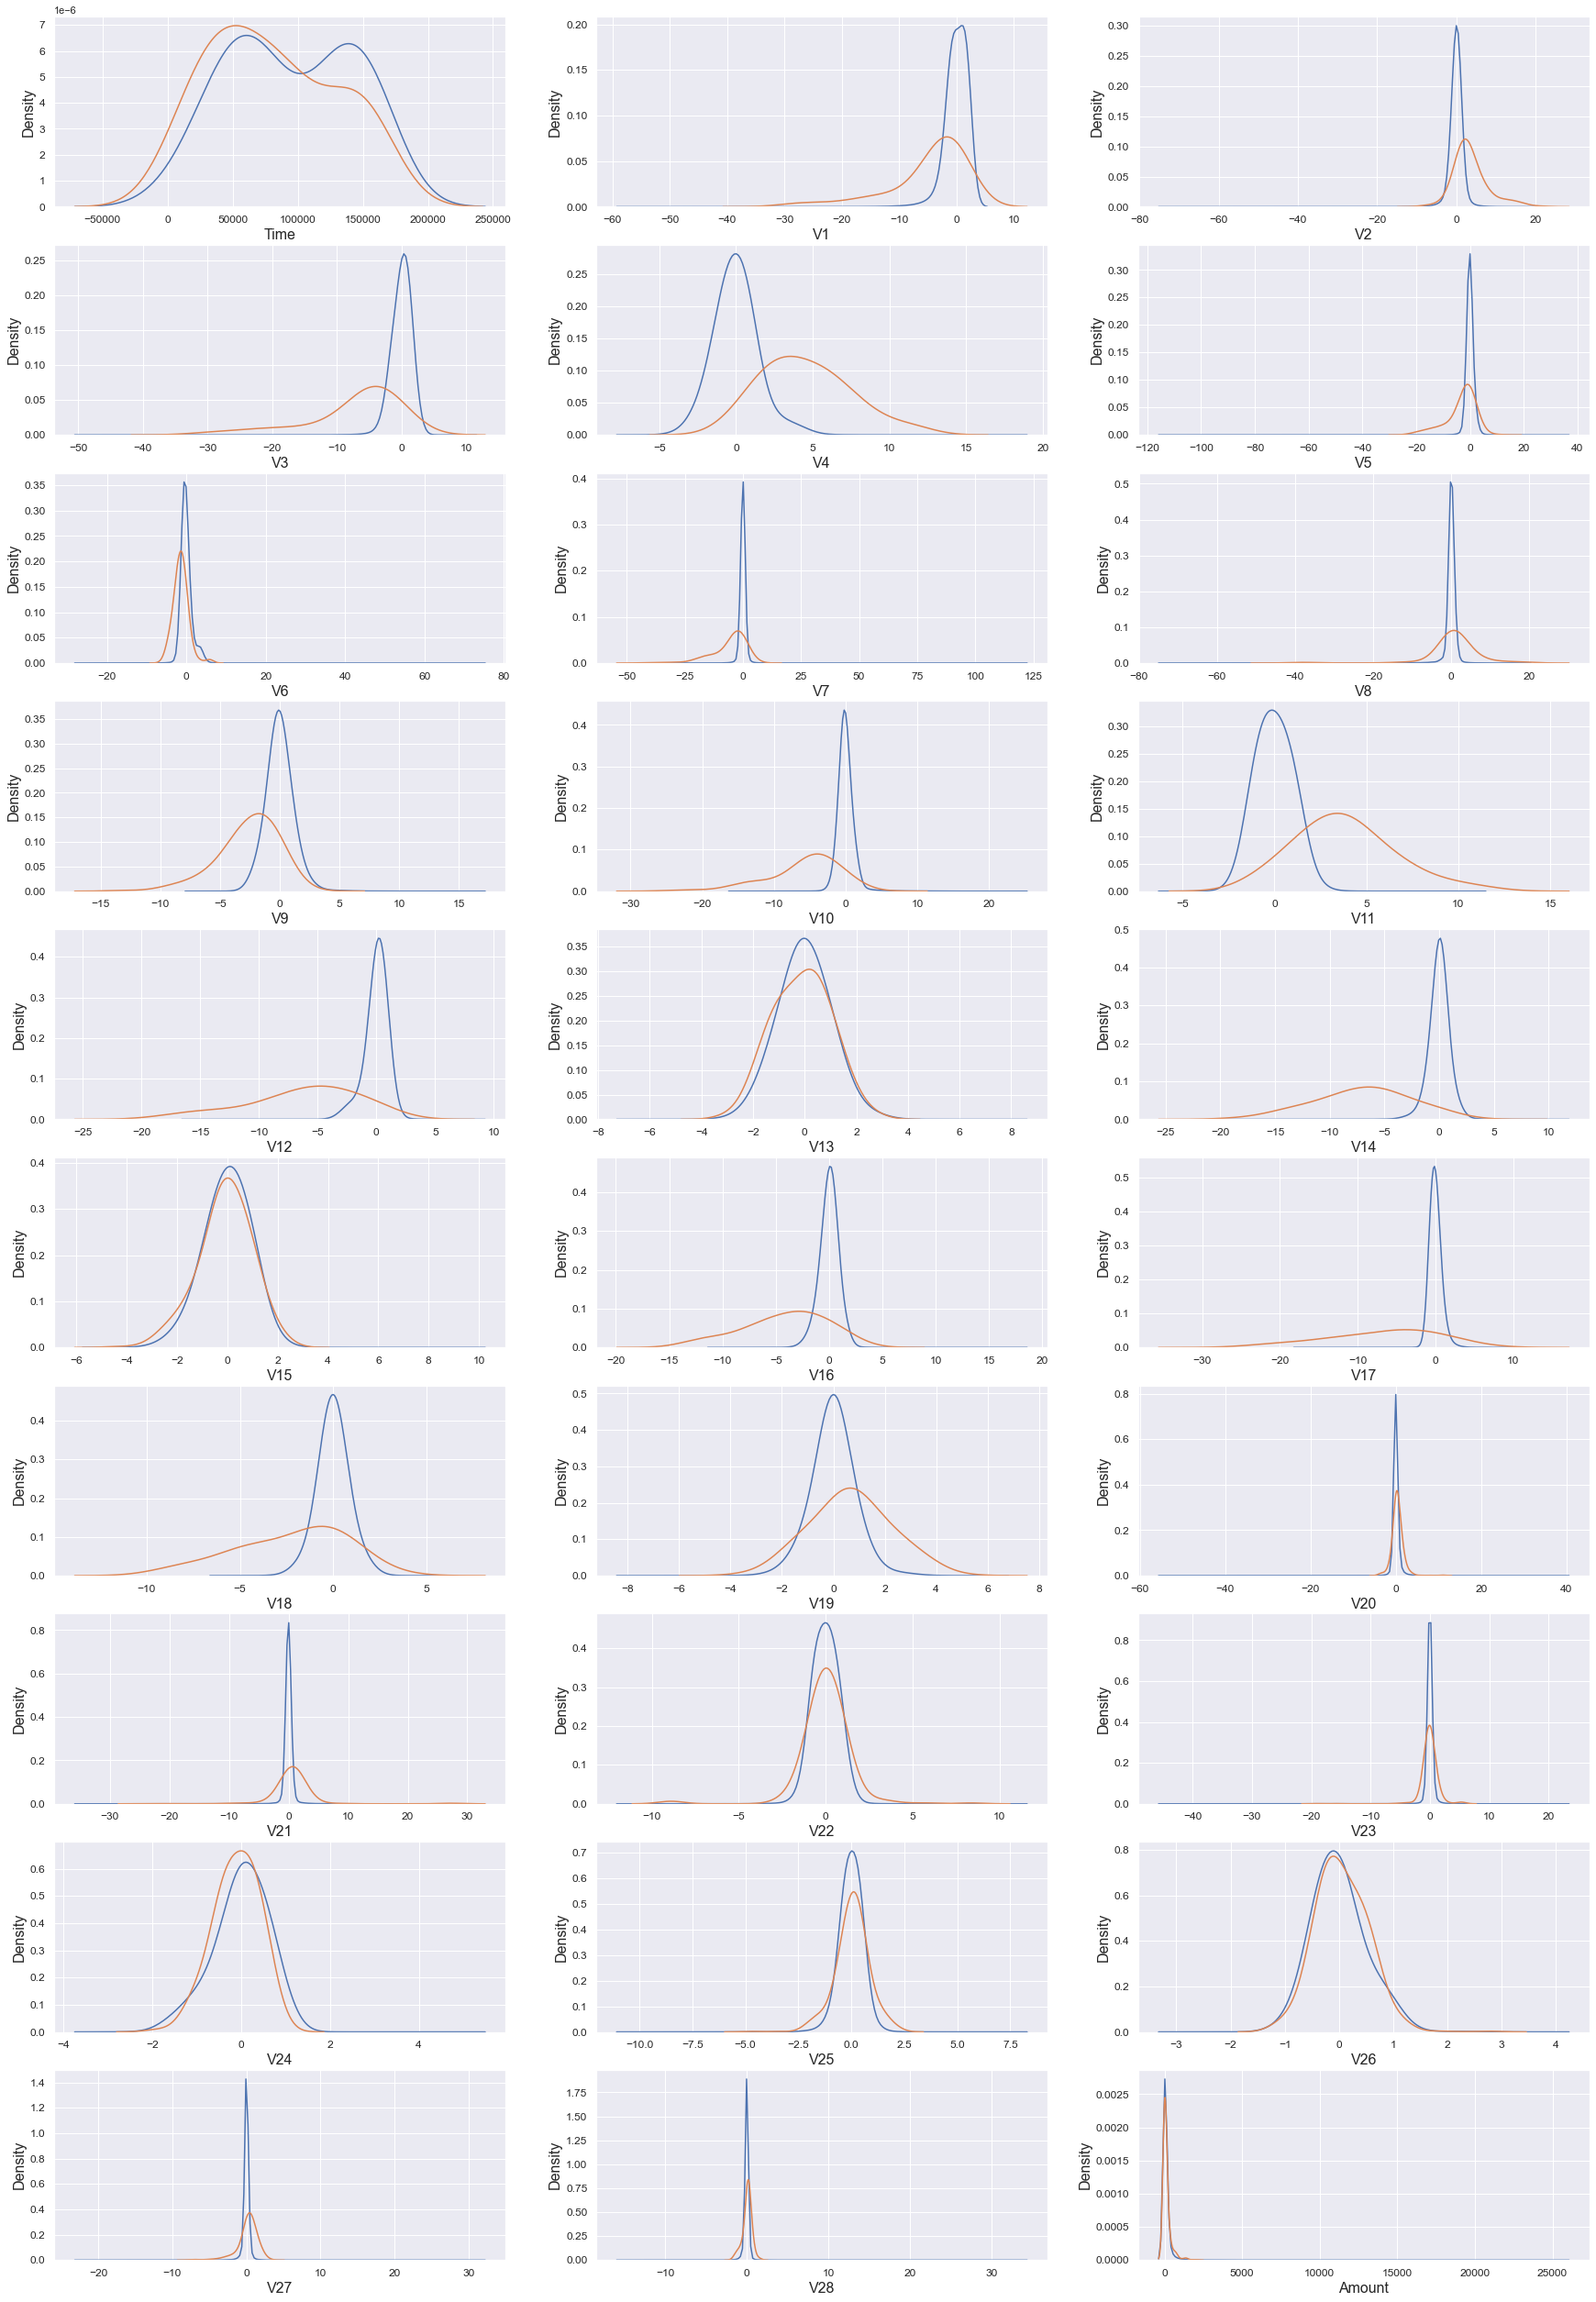

In [57]:
# checking how skewness of the data across the fields
var = list(new_df.columns.values)
# dropping Class columns from the list
var.remove("Class")

i = 0
t0 = data.loc[data['Class'] == 0]
t1 = data.loc[data['Class'] == 1]



plt.figure()
fig, ax = plt.subplots(10,3,figsize=(30,45));

for feature in var:
    i += 1
    plt.subplot(10,3,i)
    sns.kdeplot(t0[feature], bw=0.5,label="0")
    sns.kdeplot(t1[feature], bw=0.5,label="1")
    plt.xlabel(feature, fontsize=16)
    plt.ylabel("Density", fontsize=16)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

# ML Models


In [58]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

In [59]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
df_ml = spark.createDataFrame(new_df)
win = Window().orderBy('Time')
df_ml = df_ml.withColumn("idx", row_number().over(win))

In [60]:
feature_columns = [col for col in df_ml.columns if col.startswith("V")]
print(feature_columns)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


In [61]:
# Transforming columns to single vector
vectorizer = VectorAssembler(inputCols = feature_columns, outputCol="features")
vectorizer.transform(df_ml).select("features", "Class").limit(5).toPandas()

,features,Class
0,"[2.01848640169552, 0.0280090405693319, -0.6078...",0
1,"[-0.430330205681344, 0.985632693552081, 0.6457...",1
2,"[-0.356326154090313, 1.43530513012275, -0.8135...",1
3,"[0.0220569626918789, -0.55864123187364, 1.6537...",0
4,"[-17.5189091261484, 12.5721178535385, -19.0385...",1


In [62]:
# Splitting Data
df_train, df_test = df_ml.randomSplit(weights=[0.7, 0.3], seed = 1)


In [63]:
# Train Data
print("Train Data")
df_train.groupBy("Class").count().show()
print("Test Data")
df_test.groupBy("Class").count().show()

Train Data
+-----+-----+
|Class|count|
+-----+-----+
|    0|  358|
|    1|  353|
+-----+-----+

Test Data
+-----+-----+
|Class|count|
+-----+-----+
|    0|  134|
|    1|  139|
+-----+-----+



## Random Forest Classifier

In [66]:
rfc = RandomForestClassifier()
rfc.setLabelCol("Class")


evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol("Class")
paramGrid = ParamGridBuilder()\
  .addGrid(rfc.maxDepth,  [5, 10, 15, 20])\
  .build()
cv = CrossValidator(estimator=rfc, evaluator=evaluator, estimatorParamMaps=paramGrid)

pipeline = Pipeline()
pipeline.setStages([vectorizer,cv])
model = pipeline.fit(df_train)
predictions_rfc = model.transform(df_test)

evaluator.evaluate(model.transform(df_test))

0.9726457639858264

In [67]:
## Saving the model
model.write().overwrite().save("/Users/siddharthsharma/Documents/UoN-DS/Big-Data/project/team-25/model_rfc")

In [68]:
predictions_rfc.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  143|
|       1.0|  130|
+----------+-----+



In [69]:
# Accuracy of RFC
(predictions_rfc
.select("Class", "prediction")
.withColumn("Equal", expr("Class == prediction"))
.select(avg(expr("cast(Equal as float)")*100).alias("Accuracy"))).show()

+-----------------+
|         Accuracy|
+-----------------+
|93.04029304029304|
+-----------------+



In [70]:
t_p = predictions_rfc[(predictions_rfc['Class'] == 1) & (predictions_rfc['prediction']== 1)].count()
t_n = predictions_rfc[(predictions_rfc['Class'] == 0) & (predictions_rfc['prediction'] == 0)].count()
f_p = predictions_rfc[(predictions_rfc['Class'] == 0) & (predictions_rfc['prediction'] == 1)].count()
f_n = predictions_rfc[(predictions_rfc['Class'] == 1) & (predictions_rfc['prediction'] == 0)].count()
print("True Positive: ",t_p )
print("True Negative: ",t_n )
print("False Positive: ",f_p )
print("False Negative: ",f_n )
print("Recall: ",t_p/(t_p + f_n))
print("Precision: ", t_p/(t_p + f_p))
print("f-measure:", (2 * t_p) / (2 * t_p + f_p + f_n))

True Positive:  125
True Negative:  129
False Positive:  5
False Negative:  14
Recall:  0.8992805755395683
Precision:  0.9615384615384616
f-measure: 0.929368029739777


## Decision Tree

In [72]:
dtc = DecisionTreeClassifier()
dtc.setLabelCol("Class")

evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol("Class")
paramGrid = ParamGridBuilder()\
  .addGrid(dtc.maxDepth,  [5,10, 15, 20] )\
  .build()
cv_d = CrossValidator(estimator=dtc, evaluator=evaluator, estimatorParamMaps=paramGrid)


pipeline_dtc = Pipeline()
pipeline_dtc.setStages([vectorizer, cv_d])
model_dtc = pipeline_dtc.fit(df_train)
predictions_dtc = model_dtc.transform(df_test)

evaluator.evaluate(model_dtc.transform(df_test))

0.9322452485772577

In [73]:
## Saving the model
model_dtc.write().overwrite().save("/Users/siddharthsharma/Documents/UoN-DS/Big-Data/project/team-25/model_dtc")

In [74]:
# Accuracy of DTC
(predictions_dtc
.select("Class", "prediction")
.withColumn("Equal", expr("Class == prediction"))
.select(avg(expr("cast(Equal as float)")*100).alias("Accuracy"))).show()

+-----------------+
|         Accuracy|
+-----------------+
|91.57509157509158|
+-----------------+



In [75]:
predictions_dtc.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  137|
|       1.0|  136|
+----------+-----+



In [76]:
t_p = predictions_dtc[(predictions_dtc['Class'] == 1) & (predictions_dtc['prediction']== 1)].count()
t_n = predictions_dtc[(predictions_dtc['Class'] == 0) & (predictions_dtc['prediction'] == 0)].count()
f_p = predictions_dtc[(predictions_dtc['Class'] == 0) & (predictions_dtc['prediction'] == 1)].count()
f_n = predictions_dtc[(predictions_dtc['Class'] == 1) & (predictions_dtc['prediction'] == 0)].count()
print("True Positive: ",t_p)
print("True Negative: ",t_n)
print("False Positive: ",f_p)
print("False Negative: ",f_n)
print("Recall: ",t_p/(t_p + f_n))
print("Precision: ", t_p/( t_p + f_p))
print("f-measure:", (2 * t_p) / (2 * t_p + f_p + f_n))

True Positive:  126
True Negative:  124
False Positive:  10
False Negative:  13
Recall:  0.9064748201438849
Precision:  0.9264705882352942
f-measure: 0.9163636363636364


## GBT Classifier

In [78]:
gbt = GBTClassifier()
gbt.setLabelCol("Class")
paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [5,10, 15, 20])\
  .build()
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol("Class")
cv_g = CrossValidator(estimator=gbt, evaluator=evaluator, estimatorParamMaps=paramGrid)

pipeline_gbt = Pipeline()
pipeline_gbt.setStages([vectorizer, cv_g])
model_gbt = pipeline_dtc.fit(df_train)
predictions_gbt = model_gbt.transform(df_test)

evaluator.evaluate(model_gbt.transform(df_test))

0.9322452485772577

In [79]:
## Saving the model
model_gbt.write().overwrite().save("/Users/siddharthsharma/Documents/UoN-DS/Big-Data/project/team-25/model_gbt")

In [80]:
predictions_gbt.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  137|
|       1.0|  136|
+----------+-----+



In [81]:
# Accuracy of GTB
(predictions_gbt
.select("Class", "prediction")
.withColumn("Equal", expr("Class == prediction"))
.select(avg(expr("cast(Equal as float)")*100).alias("Accuracy"))).show()

+-----------------+
|         Accuracy|
+-----------------+
|91.57509157509158|
+-----------------+



In [3]:
t_p = predictions_gbt[(predictions_gbt['Class'] == 1) & (predictions_gbt['prediction']== 1)].count()
t_n = predictions_gbt[(predictions_gbt['Class'] == 0) & (predictions_gbt['prediction'] == 0)].count()
f_p = predictions_gbt[(predictions_gbt['Class'] == 0) & (predictions_gbt['prediction'] == 1)].count()
f_n = predictions_gbt[(predictions_gbt['Class'] == 1) & (predictions_gbt['prediction'] == 0)].count()
print("True Positive: ",t_p)
print("True Negative: ",t_n)
print("False Positive: ",f_p)
print("False Negative: ",f_n)
print("Recall: ",t_p/ (t_p+f_n) )
print("Precision: ", t_p/ (t_p+f_p) )
print("f-measure:", (2 * t_p) / (2 * t_p + f_p + f_n))

SyntaxError: unexpected EOF while parsing (<ipython-input-3-8c3a49429294>, line 11)